# Build and score a neural network model in real time with PyBrain and IBM Streams

If you have a neural network model and would like to score it on real time data, follow this notebook to see how to use the IBM Streams Python API to do so.

This Python notebook creates a sample data set and then creates a model for the sample data using [PyBrain](http://pybrain.org/).
Next, it creates a streaming application to score the model on a stream of simulated data. The application can run in the Streaming Analytics service in the IBM Cloud or in IBM Cloud Pak for Data.

Finally, the notebook connects to the running application to visualize the results of scoring the model on the stream of data.


Familiarity with Python and Jupyter Notebooks is recommended. 
This notebook runs on Python.

## Table of contents
***
1.	[Setup](#setup)
1.  [Create a sample data set](#create_data)
1.  [Create a model for sample data](#create_model)
1.  [Use the model in a real-time streaming application](#use_model)
1.	[Define and submit the streaming application](#build)
1.	[View the streaming data](#visualize)
1.	[Summary and next steps](#summary)
***

<a id="setup"></a>
## 1. Setup
<br/>

Before you can use the example Python code in this notebook, complete these steps:
1.	[Install Python library](#install)
1.	[(Optional) Start the Streaming Analytics service](#start)
1.	[Set up access to the service](#access)

<a id="install"></a>
### 1.1. Install PyBrain

Run the following cell to install the latest package from <a href="http://www.pybrain.org/docs/" target="_blank" rel="noopener noreferrer">PyBrain</a>. PyBrain is a machine learning library for Python and it's required to:

 - Create sample data that shows the average temperature of an engine for a given period of time, and calculates the engine's probability of failure.
 - Create a data model that reads the temperature of an engine and calculates the engine's probability of failure based on temperature readings.   
 - Use the data model in a streaming application.
 
**Note:** this notebook uses the `pybrain3` wrapper for pybrain.

In [1]:
!pip install pybrain3

### 1.1.1 Check  the version of the Streams Python API
The `streamsx` package should be at least version 1.13.14.

Verify using the cell below, 

In [2]:
!pip show streamsx

Name: streamsx
Version: 1.13.15
Summary: IBM Streams Python Support
Home-page: https://github.com/IBMStreams/pypi.streamsx
Author: IBM Streams @ github.com
Author-email: debrunne@us.ibm.com
License: Apache License - Version 2.0
Location: /opt/conda/envs/Python36/lib/python3.6/site-packages
Requires: dill, requests, future
Required-by: 


#### Upgrade if needed
If the version is older than 1.13.14,  uncomment the cell below to upgrade the package. You may have to restart the kernel after the upgrade to use the newly installed version.

In [ ]:
#!pip install --upgrade streamsx 

<a id="start"></a>
### 1.2 (Optional) Start the Streaming Analytics service

<div class="alert alert-block alert-success">You can skip this section and go to step 1.3 if you already set up the Streaming Analytics service, or if you are using IBM Cloud Pak for Data.</div>


Open the IBM Cloud web portal and <a href="https://cloud.ibm.com/registration" target="_blank" rel="noopener noreferrer">log in or sign up for a free IBM Cloud account</a>.

Ensure that your Streaming Analytics service is running in IBM Cloud.

**If you don’t have a service,** you can create one as follows:  
1. Click **Catalog** or **Create Service**, browse for the `Streaming Analytics` and then click it. <br>
1. Follow the instructions on the  Streaming Analytics catalog page. You can keep the default name, or type the *Service name* to set up your service.

1. Click **Create** to open the Streaming Analytics service dashboard.<br> Your service starts automatically.

<a id="access"></a>
### 1.3 Set up access to the service

To submit the application for execution, you have to connect to the Streams instance. The application is always the same, but the information required to connect to the instance depends on the target installation of Streams.

- [I'm running the notebook from an IBM Cloud for Data project](#cpd)
- [I'm using IBM Watson Studio, Jupyter Notebooks, or any other development environment](#notcpd)

    



<a name="cpd"></a>

### 1.3a Connect to a Streams instance from an IBM Cloud Pak for Data  project

1. From the navigation menu, click **My instances**.
2. Click the **Provisioned Instances** tab.
3. Update the value of `streams_instance_name` in the cell below according to your Streams instance name
4. Run the cell and skip to section 1.2

The cell below defines a function called `submit_topology` that will be used later on to submit the application in [step 5](#build)


In [ ]:
from icpd_core import icpd_util
from streamsx.topology import context

streams_instance_name = "Streaming Analytics-7z" ## Change this to Streams instance
cfg=icpd_util.get_service_instance_details(name=streams_instance_name)

def submit_topology(topo):
    global cfg
    # Disable SSL certificate verification if necessary
    cfg[context.ConfigParams.SSL_VERIFY] = False
    # Topology wil be deployed as a distributed app
    contextType = context.ContextTypes.DISTRIBUTED
    return context.submit (contextType, topo, config = cfg)

<a name="notcpd"></a>
### 1.3b Connect to a Streams instance from IBM Watson Studio and other envrionments

1. Visit the development guide to get <a target="blank" href="https://ibmstreams.github.io/streamsx.documentation/docs/python/1.6/python-appapi-devguide-3/#1-set-up-a-connection-to-the-streams-instance"> connection instructions</a> for Watson Studio.

2. Choose the tab that best matches your environment. Copy the code under the heading **Copy this code snippet**.
3. Paste it in the cell below.

The snippet you copy will define a function called `submit_topology` that will be used in on to submit the Streams application once it is created.    



In [3]:
## Paste snippet from development guide
from streamsx.topology.context import ConfigParams
from streamsx.topology import context
import json
import getpass
        
        
service_cfg  = {}
        
SA_credentials=getpass.getpass('Streaming Analytics credentials:')
service_cfg[ConfigParams.SERVICE_DEFINITION] = json.loads(SA_credentials)

def submit_topology(topo):
    global service_cfg
    service_cfg[context.ConfigParams.SSL_VERIFY] = False

    # This specifies how the application will be deployed

    contextType = context.ContextTypes.STREAMING_ANALYTICS_SERVICE

    return context.submit (contextType, topo, config = service_cfg) 

Streaming Analytics credentials:········


<a id="create_data"></a>
## 2. Create a sample data set

Run the following cell to create a sample data set. The x-axis shows the average temperature of an engine over the past two hours, and the y-axis shows the probability that the engine will fail in the next 30 minutes.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc0cb16a7f0>)

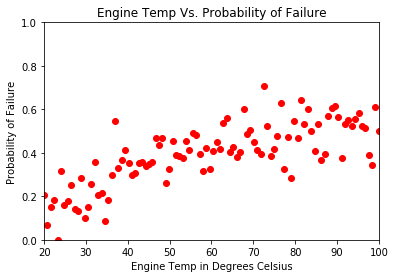

In [4]:
%matplotlib inline

import numpy as np, math
import matplotlib.pyplot as plt
from pybrain3.datasets import SupervisedDataSet
from pybrain3.structure import SigmoidLayer, LinearLayer
from pybrain3.tools.shortcuts import buildNetwork
from pybrain3.supervised.trainers import BackpropTrainer

# Create sample dataset
xvalues = np.linspace(20,100, 100)
yvalues = np.array([((np.cos((x-50)/100)*100 + np.sin(x/100)*100 + np.random.normal(0, 13, 1)[0])/150.0) for x in xvalues])
yvalues = [y - np.amin(yvalues) for y in yvalues]

CHART_TITLE = "Engine Temp Vs. Probability of Failure"
X_AXIS_LABEL = "Engine Temp in Degrees Celsius"
Y_AXIS_LABEL = "Probability of Failure"
# Plot dataset
def create_plot(xvalues, yvalues, title=None, xlabel=None, ylabel=None, xlim=None, ylim=None):
    fig, ax = plt.subplots()
    plt.title(CHART_TITLE)
    plt.ylabel(Y_AXIS_LABEL)
    plt.xlabel(X_AXIS_LABEL)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.plot(xvalues,
            yvalues, "ro", linewidth = 2, color = 'red', label = 'target')
    return fig,ax

create_plot(xvalues, yvalues, title=CHART_TITLE, xlabel = X_AXIS_LABEL, 
            ylabel = Y_AXIS_LABEL, xlim = (20,100), ylim = (0,1))

<a id="create_model"></a>
## 3. Create a model for sample data

You can now create a model which takes an engine's temperature reading, and provides an approximate probability of failure. To create this model, use the PyBrain library which trains a feedforward neural network (FFN) to predict failure probability of the engine. 

Run the following cell to see the model improving itself interactively. The blue line shows the model's fit to the data.

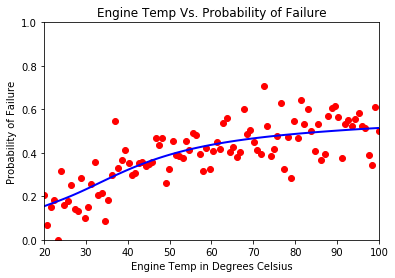

In [5]:
# The neural net to be trained
net = buildNetwork(1,100,100,100,1, bias = True, hiddenclass = SigmoidLayer, outclass = LinearLayer)

# Construct a data set of the training data
ds = SupervisedDataSet(1, 1)
for x, y in zip(xvalues, yvalues):
    ds.addSample((x,), (y,))

# The training harness. Used to train the model.
trainer = BackpropTrainer(net, ds, learningrate = 0.0001, momentum=0, verbose = False, batchlearning=False)

# Train the model. Display the model in the plot on each iteration.
fig, ax = create_plot(xvalues, yvalues, title=CHART_TITLE, xlabel = X_AXIS_LABEL ,
            ylabel = Y_AXIS_LABEL, xlim = (20,100), ylim = (0,1))

ax.plot(xvalues, [net.activate([x]) for x in xvalues], linewidth = 2, color = 'blue', label = 'NN output')

for i in range(50):
    trainer.train()
    new_yvalues = [net.activate([x]) for x in xvalues]
    ax.lines[1].set_ydata(new_yvalues)
    fig.canvas.draw()   

<a id="use_model"></a>
## 4. Use the model in a real-time streaming application

In the above cell, you trained a model to predict failure given a temperature reading. This model is represented as a Python object called `net`.

Now, you can score the model in real time using the streamsx.topology Python API.

First, define two classes that will create and score the streaming data. These classes will be used in the next section when we create the streaming application.


The `periodicSource` class simulate sample temperature readings by submitting a random number between 20 and 100 every 0.1 seconds. 

The `neural_net_model` class scores the model on each data item, or tuple in the stream produced by the `periodicSource` class.
It feeds each tuple it receives to the neural net, and returns the output from the neural net onto a stream.



In [6]:
# The source of our data. Every 0.1 seconds, a number between 20-100 will be inserted into the stream
# INPUT: None
# OUTPUT: A float with range [20,100]
class periodicSource(object):
    def __call__(self):
        while True:
            time.sleep(0.1)
            yield random.uniform(20,100)

# A class which runs the neural net on data it is passed.
# INPUT: the input to the neural net, in this case a floating point number
# OUTPUT: an array containing the output of the neural net, as well as the input to the neural net.
class neural_net_model(object):
    def __init__(self, net):
        self.my_net = net
    def __call__(self, num):
        return dict(temp=num, probability=self.my_net.activate([num])[0])

<a id="build"></a>
## 5. Define and submit the streaming application


We want to create an application that will use the PyBrain model we just created to score a stream of temperature readings. For each incoming temperature reading, it will produce a probability of engine failure at that temperature.


Here is the graph of the application we want to create:
<img src='https://developer.ibm.com/streamsdev/wp-content/uploads/sites/15/2019/10/PyBrainPredictions.png'/>


<h2>How it works</h2>

The preceeding graph represents our Streams application, which is also called a `Topology`. 

Each node in the graph is a transform that processes and/or produces data. The arrows between each node are [`Streams`](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.topology.html#stream). 

A `Stream` is a potentially infinite sequence of data to analyze.

- The **`Source`** transform produces a `Stream` uses the  `periodicSource` class to produce a `Stream` of temperature readings.


- The **`ScoreModel`** transform uses the `neural_net_model` class to score the model on the stream of temperature readings. It produces a new `Stream` that contains the probability of failure calculations. 


- The **`print`** transform prints the results to the console, while the **`PublishPredictions`**  publishes the results so [other Streams applications can access it](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.html#microservices).  


- Each tuple on the `Stream` has the format `{'temp': 46.21446887679611, 'probability': 0.3277399741231406}`.


- A [`View`](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.topology.html#streamsx.topology.topology.View) of the results stream is also is created to access the contents of the `probability_stream` from this notebook or any other application.


Finally, you run the application using the `submit_topology` function we defined earlier.  It will be submitted to the Streams instance you specified.




In [7]:
from streamsx.topology import topology, context
import random
import json 
import time

# Define operator
periodic_src = periodicSource()
model_scorer = neural_net_model(net)

# Build Graph
topo = topology.Topology("EngineFailurePrediction")

inputStream = topo.source(periodic_src, name="inputStream")

#score the model on the input stream, using Stream.map() and the neural_net_model class
# this creates a new stream of results called probability_stream

probability_stream = inputStream.map(model_scorer, name="ScoreModel")

#Various ways to use the stream: 
#1. Print the results to stdout

probability_stream.print()


#2.publish it so that other Streams applications can connect to it
probability_stream.publish(topic="PublishPredictions", name="PublishPredictions") 

# 3.create a view so that we can analyze the data right in the notebook
view = probability_stream.view(name="Predictions")

# Next steps, comment out these lines for more examples
#  
# 4. Filter out only those tuples with a high probablity of failure and print the results to stdout
# failure_likely = probability_stream.filter(lambda x: x['probability'] > 75)
# failure_likely.print()

# 5. Visualize only those temperatures that will fail soon 
# view = failure_likely.view()

topo.add_pip_package("pybrain3")
topo.add_pip_package("structure")

#Submit
print("Submitting Topology to Streams for execution..")
submission_result = submit_topology(topo)

if submission_result.job:
    streams_job = submission_result.job
    print ("JobId: ", streams_job.id , "\nJob name: ", streams_job.name)
else:
    print("Submission failed: "   + str(submssion_result))


2019-12-02 19:18:59,922 - __PROJECT_LIB__ - ERROR - ProjectHandle: Project ID neither provided nor found in the environment.
ERROR:__PROJECT_LIB__:ProjectHandle: Project ID neither provided nor found in the environment.


Submitting Topology to Streams for execution..


IntProgress(value=0, bar_style='info', description='Initializing', max=10, style=ProgressStyle(description_wid…

JobId:  1 
Job name:  notebook::EngineFailurePrediction_1


<a id="visualize"></a>
## 6. View the streaming data

You can now visualize the model in Jupyter by calling the `start_data_fetch` method of the view. This method opens a connection to the running Streams application so that we can retrieve the stream of results from the view.

The result stream is used to create a graph plotting the engine temperatures to its probability of failure as predicted by the model.

After running this cell, you should see output like this:
<img src="https://developer.ibm.com/streamsdev/wp-content/uploads/sites/15/2019/11/engine-failure.gif" alt="graph updating"></img>

<IPython.core.display.Javascript object>


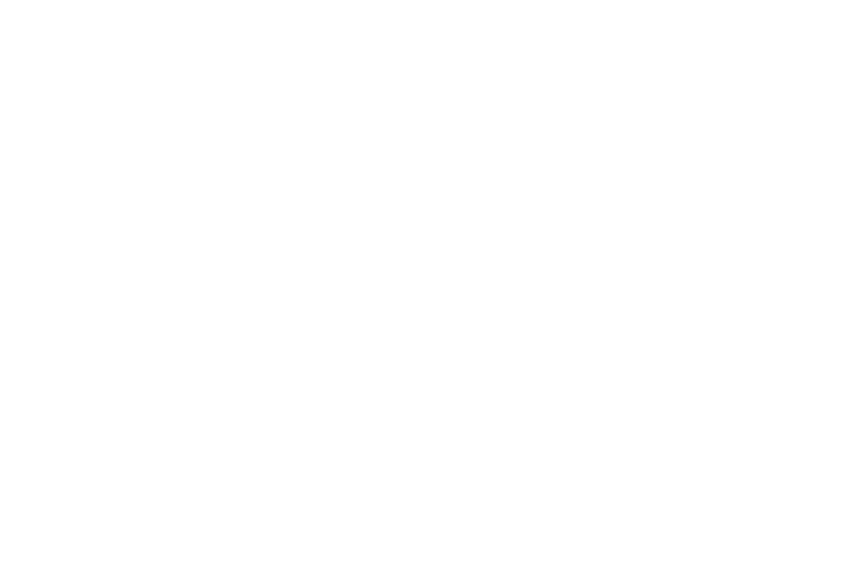

Done updating graph


<IPython.core.display.Javascript object>


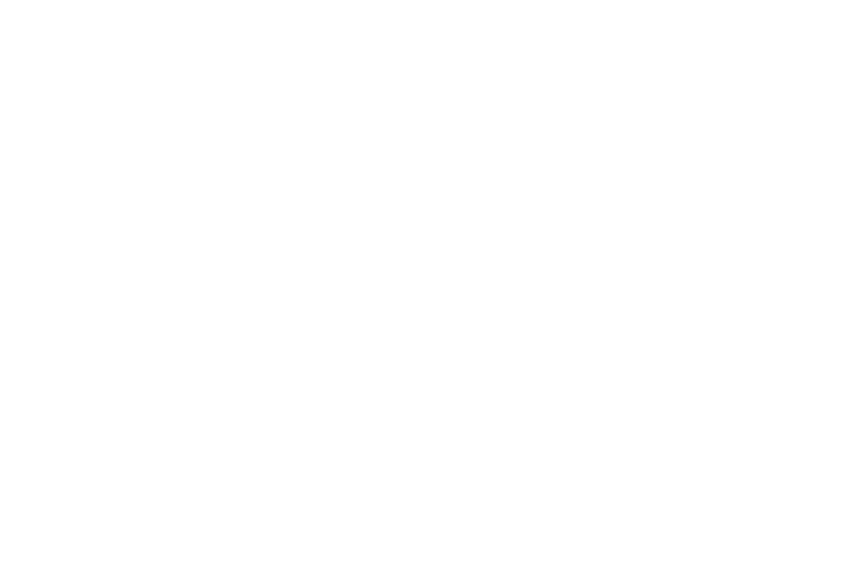

In [8]:
%matplotlib notebook


    
try:
    queue = view.start_data_fetch()
    fig, ax = create_plot([], [], title=CHART_TITLE, xlabel = X_AXIS_LABEL, 
            ylabel = Y_AXIS_LABEL, xlim = (20,100), ylim = (0,1))
    xdata = []
    ydata = []
    for i in range(100):
            line = queue.get()
            xdata.append(line["temp"])
            ydata.append(float(line["probability"]))
            ax.lines[0].set_xdata(xdata)
            ax.lines[0].set_ydata(ydata)
            fig.canvas.draw()
except:
    raise
finally:
    view.stop_data_fetch()
    print("Done updating graph")

## 6.1 (Optional) Manage the running job
If you have a problem, or if you would like to view job logs and metrics, open the Streams Console. This information is also available in the Job Graph in IBM Cloud Pak for Data.

The steps to access the Console depend on your Streams instance.
[See the development guide for details](http://ibmstreams.github.io/streamsx.documentation/docs/python/1.6/python-appapi-devguide-3/#42-see-job-status).

## 6.1 Stop the running job
The Streams job will run indefinitely until it is cancelled.
Use `submission_result.job.cancel()` to cancel it.

In [ ]:
if submission_result.job.cancel():
    print("Cancelled job")


<a id="summary"></a>
## 7. Summary and next steps

You learned how to create a sample data set, create a model for the sample data, and use that data model in a streaming application. You also learned how to visualize the streaming data, and then submit the streaming application to the Streaming Analytics service on IBM Cloud. 




- Try the <a href="https://github.com/IBMStreams/sample.starter_notebooks/blob/master/Streams-RollingAverageSample.ipynb" target="_blank" rel="noopener noreferrer">Rolling average sample notebook</a> to see other features of the Streams Python API.
- Visit the <a href="https://github.com/IBMStreams/sample.starter_notebooks/">sample notebooks repository on GitHub</a> for more samples.

### Dig deeper:
 - <a href="http://ibmstreams.github.io/streamsx.documentation/docs/latest/python/python-appapi-devguide/#developing-ibm-streams-applications-with-python" target="_blank" rel="noopener noreferrer">Developing IBM Streams applications with Python</a>
 - <a href="https://www.ibm.com/support/knowledgecenter/SSCRJU/SSCRJU_welcome.html" target="_blank" rel="noopener noreferrer">IBM Streams documentation</a> 
 
### Authors
 Will Marshall is a software developer who specializes in streaming technology and cloud solutions. 
 

Copyright © 2017-2019 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>